In [1]:
import sys
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

sys.path.append("..")
import utils

wave: amplitude=2, period=10


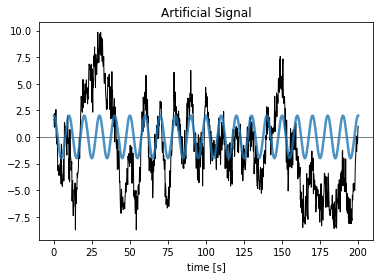

In [2]:
x, signal = utils.create_signal(
    amplitude_and_period=[(2, 10)],
    white_noise_amplitude=1,
    red_noise_amplitude_and_r1=(3.5, 0.99),
)

In [3]:
def ps(x, signal):
    # compute power spectrum
    n = len(x)
    dx = x[1] - x[0]
    freq = np.fft.rfftfreq(n, d=dx)
    signal_fft = np.fft.rfft(signal, norm="forward")
    signal_power = np.square(np.abs(2 * signal_fft))
    T = 1 / freq
    return T, signal_power


def plot_ps(T, power):
    # plot power spectrum
    fig, ax = plt.subplots()
    ax.plot(T, power)

    ax.set_xscale("log")
    ax.xaxis.set_major_formatter(plt.ScalarFormatter())
    ax.set_xlabel("period [s]")
    ax.set_title("Power Spectral Density")

    return fig, ax

In [4]:
def ps_red_noise(ra1, dt, T):
    ps = (1 - ra1 ** 2) / (1 - 2 * ra1 * np.cos(2 * np.pi / T * dt) + ra1 ** 2)
    return ps

/tmp/ipykernel_1053/1033964348.py:8: RuntimeWarning: divide by zero encountered in true_divide
  T = 1 / freq


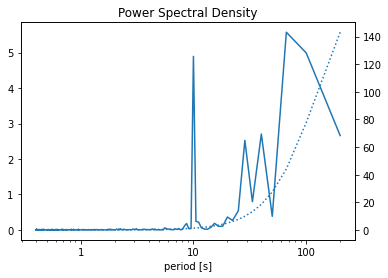

In [5]:
T, power = ps(x, signal)
fig, ax = plot_ps(T, power)

ax.twinx().plot(T, ps_red_noise(ra1=0.99, dt=x[1] - x[0], T=T), ls=":")

plt.show()

---

In [6]:
qbo_raw = utils.get_qbo()
qbo = qbo_raw.groupby("time.month") - qbo_raw.groupby("time.month").mean()
qbo = qbo.drop(
    "month"
)  # only because eofs package does not yet support dimensionless coordinates

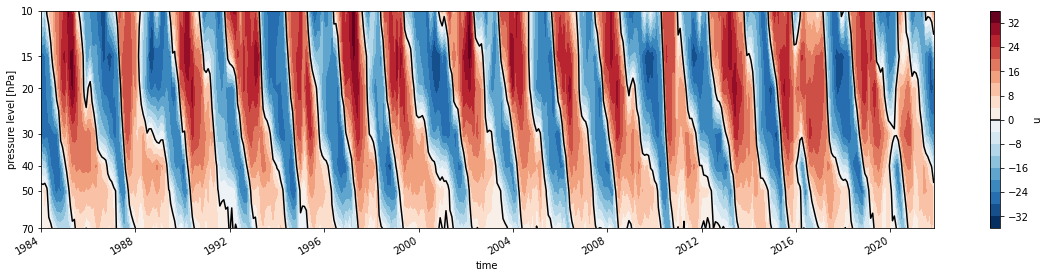

In [7]:
def nice_yticks(ax):
    ax.set_yticks(qbo.p.values)
    ax.minorticks_off()
    ax.yaxis.set_major_formatter(plt.ScalarFormatter())


fig, ax = plt.subplots(figsize=(20, 4))
res = qbo.plot.contourf(levels=20, yincrease=False, ax=ax, yscale="log")
res.colorbar.ax.axhline(0, color="k")
qbo.plot.contour(levels=[0], yincrease=False, ax=ax, colors="k", yscale="log")
nice_yticks(ax)
plt.show()

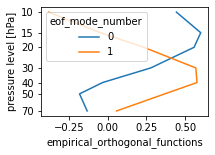

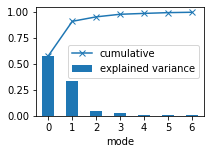

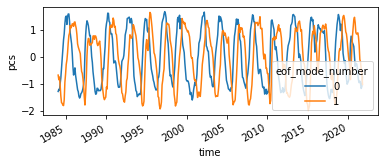

In [8]:
from eofs.xarray import Eof

solver = Eof(qbo.T)

# eofs
eofs = solver.eofs(neofs=2)

eofs.plot(hue="mode", y="p", size=2, yincrease=False, yscale="log")
nice_yticks(plt.gca())
plt.show()

# explained variance
var_expl = solver.varianceFraction()

var_expl.to_series().plot.bar(label="explained variance", figsize=(3, 2))
np.cumsum(var_expl).to_series().plot(marker="x", label="cumulative")
plt.legend(loc="center right")
plt.show()

# pcs
pcs = solver.pcs(npcs=2, pcscaling=1)

pcs.plot(hue="mode", figsize=(6, 2))
plt.show()

/tmp/ipykernel_1053/1704149568.py:11: RuntimeWarning: divide by zero encountered in true_divide
  T = 1 / freq


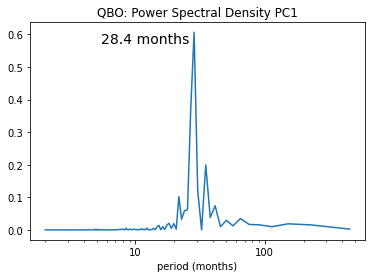

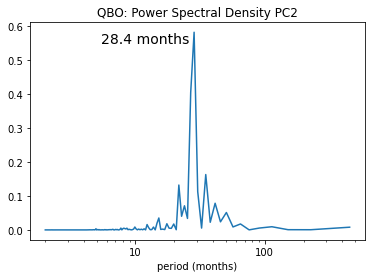

In [9]:
for mode in range(2):
    x = np.arange(len(pcs.time))
    y = pcs.sel(mode=mode).values
    
    # compute power spectrum via fft
    n = len(x)
    dx = x[1] - x[0]
    freq = np.fft.rfftfreq(n, d=dx)
    signal_fft = 2 * np.fft.rfft(y, norm="forward")
    signal_power = np.square(np.abs(signal_fft))
    T = 1 / freq
    
    # get period of maximum power
    T_max = 1 / freq[np.argmax(signal_power)]
    power_max = np.max(signal_power)
    
    # plot
    fig, ax = plt.subplots()
    ax.plot(T, signal_power)
    ax.set_xscale("log")
    ax.set_xlabel("period (months)")
    ax.xaxis.set_major_formatter(plt.ScalarFormatter())
    ax.text(
        T_max, power_max, "{:.1f} months ".format(T_max), fontsize=14, ha="right", va="top"
    )
    ax.set_title(f"QBO: Power Spectral Density PC{mode+1}")
    plt.show()